In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2022-07-01/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_train ="s3://aegovan-data/processed_dataset/train_multiclass.json"

In [3]:
is_download_files= False

In [4]:
label_order = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination", "deubiquitination",  "other"]
pos_labels = list( filter(lambda x: x != 'other', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"other" : "Negative class"}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [9]:
!ls -l $local_temp_pred_dir | wc -l

     251


In [10]:
threshold_config = {'acetylation': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.20221626758575403,
  ('confidence_std', 'std'): 0.010931891264366925,
  ('confidence_std', 'min'): 0.186287313699722,
  ('confidence_std', '25%'): 0.19900196790695102,
  ('confidence_std', '50%'): 0.20083150267601002,
  ('confidence_std', '75%'): 0.21166041493415802,
  ('confidence_std', 'max'): 0.21330013871192902,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5777932286262508,
  ('confidence', 'std'): 0.017217069729986746,
  ('confidence', 'min'): 0.555882334709167,
  ('confidence', '25%'): 0.572159707546234,
  ('confidence', '50%'): 0.57360166311264,
  ('confidence', '75%'): 0.5849224925041191,
  ('confidence', 'max'): 0.602399945259094},
 'dephosphorylation': {('confidence_std', 'count'): 29.0,
  ('confidence_std', 'mean'): 0.21133935400124204,
  ('confidence_std', 'std'): 0.07727310272430898,
  ('confidence_std', 'min'): 0.11373741179704601,
  ('confidence_std', '25%'): 0.141093701124191,
  ('confidence_std', '50%'): 0.18553803861141202,
  ('confidence_std', '75%'): 0.255215793848037,
  ('confidence_std', 'max'): 0.41554290056228604,
  ('confidence', 'count'): 29.0,
  ('confidence', 'mean'): 0.8063360175182077,
  ('confidence', 'std'): 0.13017405501056736,
  ('confidence', 'min'): 0.32787588238716103,
  ('confidence', '25%'): 0.7709274291992181,
  ('confidence', '50%'): 0.8457427024841301,
  ('confidence', '75%'): 0.8899683952331541,
  ('confidence', 'max'): 0.914224922657012},
 'deubiquitination': {('confidence_std', 'count'): 2.0,
  ('confidence_std', 'mean'): 0.1863851696252815,
  ('confidence_std', 'std'): 0.002637275825296506,
  ('confidence_std', 'min'): 0.184520334005355,
  ('confidence_std', '25%'): 0.18545275181531826,
  ('confidence_std', '50%'): 0.1863851696252815,
  ('confidence_std', '75%'): 0.18731758743524476,
  ('confidence_std', 'max'): 0.18825000524520802,
  ('confidence', 'count'): 2.0,
  ('confidence', 'mean'): 0.4542059451341625,
  ('confidence', 'std'): 0.010661192844799884,
  ('confidence', 'min'): 0.446667343378067,
  ('confidence', '25%'): 0.45043664425611474,
  ('confidence', '50%'): 0.4542059451341625,
  ('confidence', '75%'): 0.4579752460122103,
  ('confidence', 'max'): 0.461744546890258},
 'methylation': {('confidence_std', 'count'): 9.0,
  ('confidence_std', 'mean'): 0.20187029076947058,
  ('confidence_std', 'std'): 0.011129410572280824,
  ('confidence_std', 'min'): 0.185736715793609,
  ('confidence_std', '25%'): 0.19583970308303802,
  ('confidence_std', '50%'): 0.19923907518386802,
  ('confidence_std', '75%'): 0.210324048995971,
  ('confidence_std', 'max'): 0.21908366680145203,
  ('confidence', 'count'): 9.0,
  ('confidence', 'mean'): 0.7966000636418656,
  ('confidence', 'std'): 0.01647822043812186,
  ('confidence', 'min'): 0.7693868875503541,
  ('confidence', '25%'): 0.780769705772399,
  ('confidence', '50%'): 0.798503041267395,
  ('confidence', '75%'): 0.809625148773193,
  ('confidence', 'max'): 0.8169981241226191},
 'other': {('confidence_std', 'count'): 1116.0,
  ('confidence_std', 'mean'): 0.015799599189941234,
  ('confidence_std', 'std'): 0.0407698558038574,
  ('confidence_std', 'min'): 0.0008510624757030001,
  ('confidence_std', '25%'): 0.00117629769374575,
  ('confidence_std', '50%'): 0.0021780409151680004,
  ('confidence_std', '75%'): 0.007007123087532501,
  ('confidence_std', 'max'): 0.303181886672973,
  ('confidence', 'count'): 1116.0,
  ('confidence', 'mean'): 0.9903799230800303,
  ('confidence', 'std'): 0.026711376001797505,
  ('confidence', 'min'): 0.5133088827133171,
  ('confidence', '25%'): 0.9944566637277598,
  ('confidence', '50%'): 0.9974353015422815,
  ('confidence', '75%'): 0.998221039772033,
  ('confidence', 'max'): 0.9985265731811521},
 'phosphorylation': {('confidence_std', 'count'): 139.0,
  ('confidence_std', 'mean'): 0.09348429794416534,
  ('confidence_std', 'std'): 0.11442879568269237,
  ('confidence_std', 'min'): 0.006378921680152001,
  ('confidence_std', '25%'): 0.013172945939004001,
  ('confidence_std', '50%'): 0.034169171005487005,
  ('confidence_std', '75%'): 0.13673919439315751,
  ('confidence_std', 'max'): 0.469867438077926,
  ('confidence', 'count'): 139.0,
  ('confidence', 'mean'): 0.9306538756802781,
  ('confidence', 'std'): 0.09291076266425286,
  ('confidence', 'min'): 0.548133730888366,
  ('confidence', '25%'): 0.9297615289688106,
  ('confidence', '50%'): 0.9758448600769041,
  ('confidence', '75%'): 0.98560282588005,
  ('confidence', 'max'): 0.990909934043884},
 'ubiquitination': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.1845212131738658,
  ('confidence_std', 'std'): 0.010037806334405529,
  ('confidence_std', 'min'): 0.174075484275817,
  ('confidence_std', '25%'): 0.177953422069549,
  ('confidence_std', '50%'): 0.18058878183364802,
  ('confidence_std', '75%'): 0.19217012822628002,
  ('confidence_std', 'max'): 0.197818249464035,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5571501374244686,
  ('confidence', 'std'): 0.07332355556921501,
  ('confidence', 'min'): 0.42922157049179005,
  ('confidence', '25%'): 0.5765218138694761,
  ('confidence', '50%'): 0.579930007457733,
  ('confidence', '75%'): 0.58320677280426,
  ('confidence', 'max'): 0.616870522499084}}

In [11]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        list_df.append(df)
    return pd.concat(list_df)


In [12]:
def get_summary_df(local_temp_pred_dir, use_std=True, conf_percentile="50%", confidence_std_percentile="50%"):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "pubmedId", "participant1Id", "participant2Id", "participant1Name", "participant2Name"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t[('confidence', conf_percentile)]
            conf_std_median = t[('confidence_std', confidence_std_percentile)]
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            high_quality_frames_per_interaction.append(df.query(high_qry))


            # Low quality filter query
            conf_min = t[('confidence', "min")]
            conf_std_min = t[('confidence_std', "max")]
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_median)
            df_low = df.query(low_qry)
            sample=min(5000, len(df_low) )
            low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [13]:
def get_partipants_key_raw(participants):
    """
    Example input
    [{'uniprotid': 'P19388',
  'alias': [['rpab1_human'],
   ['DNA-directed RNA polymerases I, II, and III subunit RPABC1'],
   ['POLR2E'],
   ['DNA-directed RNA polymerase II subunit E'],
   ['RPB5 homolog'],
   ['DNA-directed RNA polymerase II 23 kDa polypeptide'],
   ['XAP4']],
  'alternative_uniprots': ['Q6PIH5', 'Q9BT06', 'O43380', 'B2R6L4', 'D6W5Y1']},
 {'uniprotid': 'Q96SB4',
  'alias': [['srpk1_human'],
   ['SRSF protein kinase 1'],
   ['Serine/arginine-rich protein-specific kinase 1'],
   ['SFRS protein kinase 1'],
   ['SRPK1']],
  'alternative_uniprots': ['Q5R365', 'Q5R364', 'B4DS61', 'Q8IY12', 'Q12890']}]
    """
    participant_uniprot = []
    for p in participants:
        
        participant_uniprot.append(str(p["uniprotid"]))
        
        
    result = frozenset( list(filter (lambda x: x is not None, participant_uniprot)))
    
    return result


def is_ptm_ppi_in_training(df, training_df):
    training_participants_pred = pd.DataFrame()
    training_participants_pred["pubmedId"] = training_df["pubmedId"]
    training_participants_pred["participants"] = training_df["participants"].apply(get_partipants_key_raw)
    training_participants_pred["prediction"] = training_df["interactionType"]
    training_participants_pred["ptm-ppi"] = training_participants_pred[["prediction", "participants"]].apply(tuple, axis=1)
    training_participants_pred["ptm-ppi-pubmed"] = training_participants_pred[["prediction","participants","pubmedId" ]].apply(tuple, axis=1)


    df_particpiants_pred = pd.DataFrame()
    df_particpiants_pred["pubmedId"] = df["pubmedId"]
    df_particpiants_pred["participants"] = df[["participant2Id", "participant1Id"]].apply(frozenset, axis=1)
    df_particpiants_pred["prediction"] = df["prediction"]
    df_particpiants_pred["ptm-ppi"] = df_particpiants_pred[["prediction","participants" ]].apply(tuple, axis=1)
    df_particpiants_pred["ptm-ppi-pubmed"] = df_particpiants_pred[["prediction","participants","pubmedId" ]].apply(tuple, axis=1)
 
    result = pd.DataFrame()
    result["is_in_train_ptmppi"] =  df_particpiants_pred["ptm-ppi"].isin(training_participants_pred["ptm-ppi"])
    result["is_in_train_record"]=  df_particpiants_pred["ptm-ppi-pubmed"].isin(training_participants_pred["ptm-ppi-pubmed"])
    
    
    return result


def is_in_training_pubmed(df, training_df):
    return df["pubmedId"].isin(training_df["pubmedId"])

In [14]:
download_file(s3_data, local_temp_wk_dir)
data_file = os.path.join(local_temp_wk_dir, s3_data.split("/")[-1])
data_training_full_df = pd.read_json(data_file)

In [15]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir, use_std=True)
df_high_quality_threshold[["PTMPPIInTrainingData", "RecordInTrainingData"]] = is_ptm_ppi_in_training( df_high_quality_threshold, data_training_full_df)
df_summary[["PTMPPIInTrainingData", "RecordInTrainingData"]] = is_ptm_ppi_in_training( df_summary, data_training_full_df)
df_low_quality_threshold[["PTMPPIInTrainingData", "RecordInTrainingData"]] = is_ptm_ppi_in_training( df_low_quality_threshold, data_training_full_df)

CPU times: user 1min 14s, sys: 1.84 s, total: 1min 16s
Wall time: 1min 16s


In [16]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [17]:
df_high_quality_threshold.shape

(36689, 23)

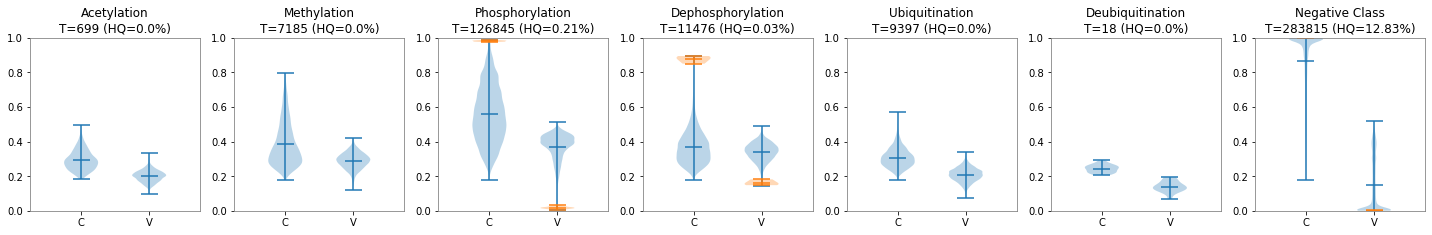

In [18]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [19]:
df_low_quality_threshold["prediction"].value_counts()

other                21720
methylation           6738
ubiquitination        5640
phosphorylation       2249
acetylation            248
dephosphorylation       16
deubiquitination         2
Name: prediction, dtype: int64

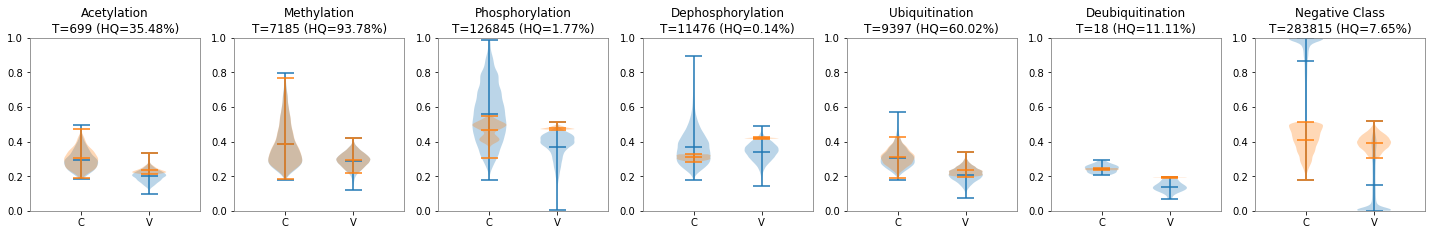

In [20]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [21]:
df_summary.shape

(439438, 10)

In [22]:
df_summary.groupby("prediction").describe().T

prediction             acetylation  dephosphorylation  deubiquitination  \
confidence     count  6.990000e+02       1.147700e+04      1.800000e+01   
               mean   2.930808e-01       3.709867e-01      2.437239e-01   
               std    5.672533e-02       9.810365e-02      2.282310e-02   
               min    1.844778e-01       1.799101e-01      2.079704e-01   
               25%    2.512852e-01       2.974839e-01      2.228585e-01   
               50%    2.857745e-01       3.582928e-01      2.458449e-01   
               75%    3.294316e-01       4.268874e-01      2.580149e-01   
               max    4.974306e-01       8.947631e-01      2.916166e-01   
confidence_std count  6.990000e+02       1.147700e+04      1.800000e+01   
               mean   2.011719e-01       3.402142e-01      1.398978e-01   
               std    3.342134e-02       5.072438e-02      3.173239e-02   
               min    9.571324e-02       1.453529e-01      6.696381e-02   
               25%    1.781769e-01       3.067458e-01      1.215737e-01   
               50%    2.023614e-01       3.441899e-01      1.375995e-01   
               75%    2.228953e-01       3.772184e-01      1.576167e-01   
               max    3.345895e-01       4.889568e-01      1.936462e-01   
pubmedId       count  6.990000e+02       1.147700e+04      1.800000e+01   
               mean   3.327039e+06       3.181249e+06      2.835417e+06   
               std    2.161681e+06       2.047374e+06      1.693707e+06   
               min    1.140000e+03       4.500000e+02      7.305440e+05   
               25%    1.715316e+06       1.714936e+06      1.903806e+06   
               50%    2.629613e+06       2.550298e+06      2.432075e+06   
               75%    6.085786e+06       3.897250e+06      3.060640e+06   
               max    7.529232e+06       7.530340e+06      7.300021e+06   

prediction             methylation         other  phosphorylation  \
confidence     count  7.185000e+03  2.838150e+05     1.268470e+05   
               mean   3.858045e-01  8.635541e-01     5.571496e-01   
               std    1.242425e-01  1.874035e-01     1.631432e-01   
               min    1.796805e-01  1.800849e-01     1.770113e-01   
               25%    2.883187e-01  7.863973e-01     4.327566e-01   
               50%    3.545788e-01  9.646357e-01     5.450867e-01   
               75%    4.601656e-01  9.958288e-01     6.754889e-01   
               max    7.954645e-01  9.985271e-01     9.897428e-01   
confidence_std count  7.185000e+03  2.838150e+05     1.268470e+05   
               mean   2.899180e-01  1.471187e-01     3.700039e-01   
               std    4.534439e-02  1.567221e-01     7.698923e-02   
               min    1.198883e-01  7.238831e-04     6.695514e-03   
               25%    2.596361e-01  4.461263e-03     3.340991e-01   
               50%    2.916409e-01  7.578858e-02     3.890232e-01   
               75%    3.213449e-01  2.947168e-01     4.247452e-01   
               max    4.184169e-01  5.188307e-01     5.109221e-01   
pubmedId       count  7.185000e+03  2.838150e+05     1.268470e+05   
               mean   3.284221e+06  3.013521e+06     3.085311e+06   
               std    2.100459e+06  2.068632e+06     1.986533e+06   
               min    5.600000e+01  3.700000e+02     6.000000e+01   
               25%    1.730025e+06  1.666843e+06     1.704032e+06   
               50%    2.727042e+06  2.197510e+06     2.479690e+06   
               75%    4.029754e+06  3.226476e+06     3.519268e+06   
               max    7.530274e+06  7.530342e+06     7.530351e+06   

prediction            ubiquitination  
confidence     count    9.397000e+03  
               mean     3.078330e-01  
               std      5.558877e-02  
               min      1.770117e-01  
               25%      2.673734e-01  
               50%      3.021228e-01  
               75%      3.419753e-01  
               max      5.720380e-01  
confidence_std count    9.397000e+03  
        

In [23]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    participants_cols = ["participant1Id", "participant2Id"]
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    df_full["participants"] = df_full[participants_cols].apply(frozenset, axis=1)
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()
    df_high_quality_threshold["participants"] = df_high_quality_threshold[participants_cols].apply(frozenset,
                                                                                                   axis=1)

        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    summary_unique_df = pd.DataFrame(df_full\
                          .groupby([ "prediction", "participants"])\
                          .size()\
                          .groupby(level=0).size())\
                          .rename(columns={0: "all_count_unique"})
    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    thresh_unique_df = pd.DataFrame(df_high_quality_threshold\
              .groupby([ "prediction", "participants"])\
              .size()\
              .groupby(level=0).size())\
              .rename(columns={0: "thresh_count_unique"})
            
    
   
    
    
    dfs = [summary_df, summary_unique_df, thresh_df, thresh_unique_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrrrr}
\toprule
{} &  all\_count &  all\_count\_unique &  thresh\_count &  thresh\_count\_unique \\
prediction        &            &                   &               &                      \\
\midrule
acetylation       &        699 &               582 &             0 &                    0 \\
dephosphorylation &      11476 &              6827 &             3 &                    3 \\
deubiquitination  &         18 &                18 &             0 &                    0 \\
methylation       &       7185 &              4260 &             0 &                    0 \\
other             &     283815 &             73756 &         36417 &                15921 \\
phosphorylation   &     126845 &             38925 &           267 &                  242 \\
ubiquitination    &       9397 &              5382 &             0 &                    0 \\
Total             &     439435 &            129750 &         36687 &                16166 \\
\bottomrule
\end{tabular}

CPU times: 

,all_count,all_count_unique,thresh_count,thresh_count_unique
prediction,,,,
acetylation,699,582,0,0
dephosphorylation,11476,6827,3,3
deubiquitination,18,18,0,0
methylation,7185,4260,0,0
other,283815,73756,36417,15921
phosphorylation,126845,38925,267,242
ubiquitination,9397,5382,0,0
Total,439435,129750,36687,16166


In [24]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
dephosphorylation        3
other                36417
phosphorylation        269
dtype: int64

In [25]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [26]:
df_all = load_df_from_files(local_temp_pred_dir)

In [27]:
from utils.static_markers_ppi_multiclass import StaticMarkerPpiMulticlass

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")



StaticMarkerPpiMulticlass().create(df_high_quality_threshold, local_file_high_q_sample,  additional_cols= ",".join( list(df_high_quality_threshold.columns)))
StaticMarkerPpiMulticlass().create(df_low_quality_threshold, local_file_low_q_sample,  additional_cols= ",".join( list(df_low_quality_threshold.columns)))




In [28]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [29]:
df_all.groupby(["prediction"]).size()

prediction
acetylation             699
dephosphorylation     11477
deubiquitination         18
methylation            7185
other                283815
phosphorylation      126847
ubiquitination         9397
dtype: int64

In [30]:
df_all.shape

(439438, 21)

In [31]:
df_all.columns

Index(['pubmedId', 'participant1Id', 'participant1Name', 'participant2Id',
       'participant2Name', 'abstract', 'normalised_abstract', 'annotations',
       'gene_to_uniprot_map', 'normalised_abstract_annotations', 'other',
       'phosphorylation', 'dephosphorylation', 'methylation', 'ubiquitination',
       'acetylation', 'deubiquitination', 'prediction', 'confidence',
       'confidence_std', 'raw_confidence'],
      dtype='object')

In [32]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
from utils.static_markers_ppi_multiclass import StaticMarkerPpiMulticlass
import pandas as pd
import tempfile

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = tempfile.mkstemp()[1]
    marker_target_file = tempfile.mkstemp()[1]


    StaticMarkerPpiMulticlass().create(ref_file_or_df, marker_ref_file)
    StaticMarkerPpiMulticlass().create(target_file_or_df, marker_target_file,  additional_cols= ",".join( additional_target_cols))
    
    
    df_ref_marker = pd.read_json(marker_ref_file)
    df_target_marker = pd.read_json(marker_target_file)
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=1050)
    comparison_result = comparer(df_ref_marker["x"].tolist(), df_target_marker["x"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [33]:
download_file(s3_train, local_temp_wk_dir)
train_data_file =  os.path.join(local_temp_wk_dir, s3_train.split("/")[-1])
training_df = pd.read_json(train_data_file)

In [34]:
t =  df_all.query("prediction == 'phosphorylation'").sample(n=10000)
df_sim_score = get_sim_scores(training_df, t, n_gram=1, additional_target_cols=list(df_all.columns))


<AxesSubplot:>

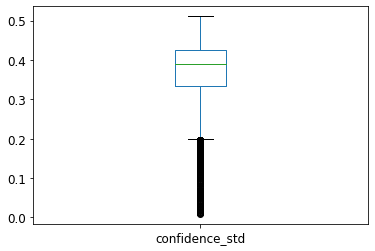

In [35]:
df_sim_score["confidence_std"].plot.box()

(0.0, 1.0)

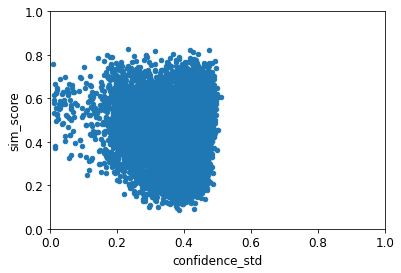

In [36]:
df_sim_score.plot.scatter(y="sim_score", x="confidence_std")
plt.ylim((0, 1.0)) 
plt.xlim((0, 1.0)) 

In [37]:
df_sim_score.query("confidence >= 0.93").shape

(86, 25)

In [38]:
t =  df_all.query("confidence >= 0.93   and confidence_std < .03 and prediction == 'phosphorylation'")
df_sim_score_high = get_sim_scores(training_df, t, n_gram=1, additional_target_cols=list(df_all.columns))



/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() inst

<AxesSubplot:>

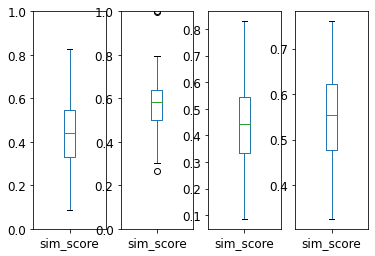

In [39]:
_,ax = plt.subplots(1,4)
ax[0].set_ylim((0, 1.0)) 
ax[1].set_ylim((0, 1.0)) 


#ax[0].set_xticks([1, 1])
df_sim_score.query("confidence < 0.93 and confidence_std > 0.03")["sim_score"].plot.box(ax=ax[0])
df_sim_score_high.query("confidence >= 0.93   and confidence_std < .03 ")["sim_score"].plot.box(ax=ax[1])
df_sim_score.query("confidence < 0.93 ")["sim_score"].plot.box(ax=ax[2])
df_sim_score.query("confidence >= 0.93   ")["sim_score"].plot.box(ax=ax[3])



In [40]:
df_sim_score["sim_score"].describe()


count    10000.000000
mean         0.440077
std          0.138298
min          0.086196
25%          0.333233
50%          0.442839
75%          0.546911
max          0.829047
Name: sim_score, dtype: float64

(0.0, 1.0)

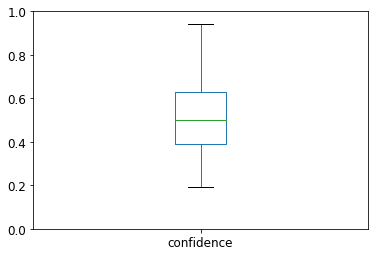

In [41]:
#ax[0].set_xticks([1, 1])
df_sim_score.query("sim_score < 0.33")["confidence"].plot.box()


plt.ylim((0, 1.0)) 


(0.0, 1.0)

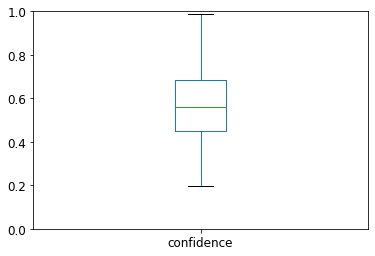

In [42]:
df_sim_score.query("sim_score >= 0.33")["confidence"].plot.box()
plt.ylim((0, 1.0)) 


<AxesSubplot:>

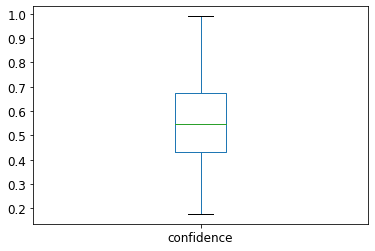

In [43]:
df_all.query("prediction == 'phosphorylation'")["confidence"].plot.box()

<AxesSubplot:>

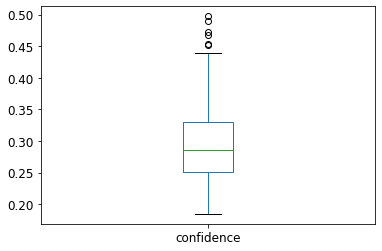

In [44]:
df_all.query("prediction == 'acetylation'")["confidence"].plot.box()

<AxesSubplot:>

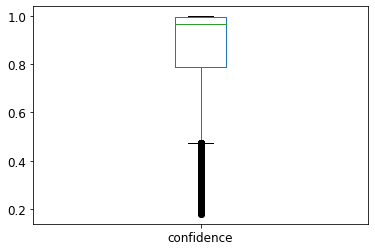

In [45]:
df_all.query("prediction == 'other'")["confidence"].plot.box()

In [46]:
df_sim_score.query("confidence >= 0.93").shape

(86, 25)

In [47]:
df_sim_score.query("confidence < 0.93").shape

(9914, 25)

In [48]:
df_sim_score.query("confidence > 0.93").sort_values(by=["confidence"]).head()

,x,y,y_raw,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,sim_score
4966,Using a characterized human PROTPART1 (PROTPAR...,0,other,3015768,P02774,vitamin D binding protein,Q10586,DBP,Using a characterized human vitamin D binding ...,Using a characterized human P02774 (Q10586) cD...,"[{'start': '22', 'end': '27', 'name': 'human',...","{'2638': 'P02774', '1628': 'Q10586'}","[{'charOffset': 28, 'len': 6, 'text': 'P02774'...",0.004089,0.930495,0.003359,0.037227,0.007448,0.006015,0.011367,phosphorylation,0.930495,0.118635,"[0.9944369793000001, 0.6849968433, 0.991866886...",0.523845
8400,We have recently identified and cloned the gen...,0,other,2267130,P04198,N-myc,P16949,oncoprotein 18,We have recently identified and cloned the gen...,We have recently identified and cloned the gen...,"[{'start': '88', 'end': '102', 'name': 'oncopr...","{'3925': 'P16949', '4613': 'P04198'}","[{'charOffset': 88, 'len': 6, 'text': 'P16949'...",0.004057,0.930540,0.004479,0.016934,0.008156,0.030731,0.005103,phosphorylation,0.930540,0.160186,"[0.9933274984, 0.4792755246, 0.9881696701, 0.9...",0.634831
2075,Serum cortisol and plasma PROTPART0 (PROTPART0...,0,other,6319947,P01189,beta-endorphin,P09848,beta-endorphin/beta-lipotrophin hormone,Serum cortisol and plasma beta-endorphin/beta-...,Serum cortisol and plasma P09848 (P09848) immu...,"[{'start': '26', 'end': '65', 'name': 'beta-en...","{'3938': 'P09848', '5443': 'P01189'}","[{'charOffset': 26, 'len': 6, 'text': 'P09848'...",0.012925,0.930595,0.007802,0.030271,0.009082,0.003972,0.005352,phosphorylation,0.930595,0.125672,"[0.9834104180000001, 0.5759060383, 0.948834955...",0.471415
7529,Vertical starch gel electrophoresis of PROTPAR...,0,other,684261,P00492,hypoxanthine-guanine phosphoribosyl transferase,P07741,adenine phosphoribosyl transferase,Vertical starch gel electrophoresis of hypoxan...,Vertical starch gel electrophoresis of P00492 ...,"[{'start': '39', 'end': '86', 'name': 'hypoxan...","{'3251': 'P00492', '353': 'P07741'}","[{'charOffset': 39, 'len': 6, 'text': 'P00492'...",0.009344,0.930833,0.006440,0.036970,0.006935,0.003891,0.005587,phosphorylation,0.930833,0.118291,"[0.9897992611, 0.9775595069, 0.9662611485, 0.8...",0.704398
8179,The genes that encode the alpha 1 (VI) and alp...,0,other,1676701,P12109,COL6A1,P12110,COL6A2,The genes that encode the alpha 1 (VI) and alp...,The genes that encode the alpha 1 (VI) and alp...,"[{'start': '84', 'end': '90', 'name': 'COL6A1'...","{'1291': 'P12109', '1292': 'P12110'}","[{'charOffset': 84, 'len': 6, 'text': 'P12109'...",0.003918,0.931262,0.003430,0.020569,0.016083,0.006405,0.018332,phosphorylation,0.931262,0.131167,"[0.9922786951, 0.5789396167, 0.991063118, 0.85...",0.532886


In [49]:
df_sim_score.query("confidence >= 0.99 ")["x"].shape

(0,)

In [50]:
df_sim_score.query("confidence < 0.99")["x"].shape

(10000,)